# SSH or Streamfunction?

We try out potential ways to make a divide between heat gain and heat loss regions. Specifically, we have the following ideas:

1. Using streamfunction, or
2. Using SSH 

to separate the subtropical from subpolar and polar gyres, and to heat up the subtropics, cool down the subpolar regions. 

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 18) 
matplotlib.rc('ytick', labelsize = 18)

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46135/status,
Dashboard: /proxy/46135/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34577,Workers: 4
Dashboard: /proxy/46135/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:34657,Total threads: 4
Dashboard: /proxy/44535/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41815,


In [2]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_param_kpp_extended2.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_param_kpp_extended2'

## A. Using streamfunction

In [3]:
rho0 = 1026
st = '2000-01-01'
et = '2009-12-31'

tx_trans = cc.querying.getvar(expt = expt, session = session, variable = 'tx_trans_int_z', frequency = '1 monthly').sel(time = slice(st, et))
psi = -tx_trans.cumsum('yt_ocean').where(abs(tx_trans<=1.e20))/(rho0*1.e6)

In [4]:
psi_acc = np.nanmin(psi.sel(xu_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)).mean('time'))
print('Max value of streamfunction south of 55S and within 69W-67W = ', psi_acc, 'Sv')

Max value of streamfunction south of 55S and within 69W-67W =  -137.57999 Sv


In [5]:
psi_g = psi.mean('time') - psi_acc
psi_g = psi_g.rename('Barotropic Stream function')
psi_g.attrs['long_name'] = 'Barotropic Stream function'
psi_g.attrs['units'] = 'Sv'

psi_g = psi_g.where(psi_g.yt_ocean > 0, -psi_g)

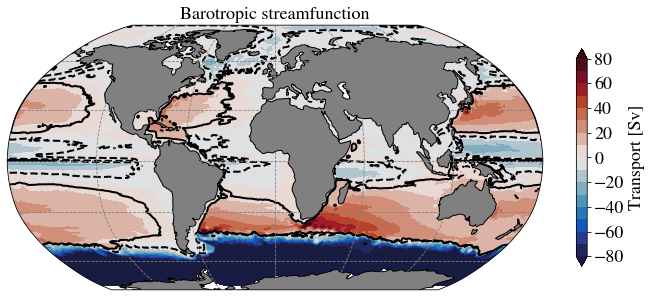

In [6]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.arange(-80, 90, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, psi_g, colors = 'black', levels = [-5, 5], transform=ccrs.PlateCarree(), add_colorbar=False)
#ax.contour(geolon_c, geolat_t, psi_g.where(psi_g.yt_ocean < -10), colors = 'black', levels = [-5, 5], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, psi_g, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]', size = 18)
ax.set_title('Barotropic streamfunction', size = 18)
plt.savefig('Figures/psi.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)

In the northern hemisphere, heat loss will occur in the region enclosed by dotted black contours, and heat gain will occur in the region enclosed by complete black contours. The opposite is true of Southern Hemisphere.

## B. Using SSH

In [7]:
SSH = cc.querying.getvar(expt = expt, session = session, variable = 'sea_level', frequency = '1 monthly').sel(time = slice(st, et))
SSH = SSH.mean('time')

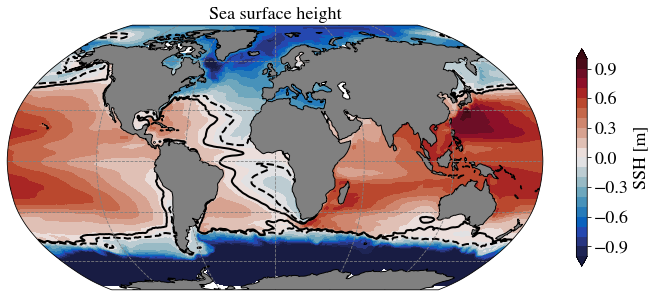

In [8]:
# Grid (used for plotting)
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

# Define the levels for the contourf
lvls = np.linspace(-1, 1, 21)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

ax.contour(geolon_c, geolat_t, SSH, colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
#ax.contour(geolon_c, geolat_t, SSH), colors = 'black', levels = [-0.05, 0.05], transform=ccrs.PlateCarree(), add_colorbar=False)
# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, SSH, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('SSH [m]', size = 18)
ax.set_title('Sea surface height', size = 18)
plt.savefig('Figures/ssh.jpeg', bbox_inches = 'tight', dpi = 900, transparent=True)